# SNN (Siamese Neural Network)
Trains the fully convolutional Network used to create the foreground mask.  
Network is based on U-Net

### Location of images:
    config.IMAGE_PATH
### XML file used to label the images (labeling done with CVAT and labes exported as '')
    config.ANNOTATION_FILE_SNN
### Batchsize used during the training of the FCN
    config.BATCH_SIZE_SNN = 50
### Epoches of the Training
    config.EPOCHES_SNN = 4

### Example label:
![Labeling for SNN](./label_examples/snn_labeling.png "Label")

Final model is saved in ../models/mask.pth


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from Training.SNN.labelHelper import LabelHelper
from Training.SNN.patchHelper import PatchHelper
from Training.SNN.patchLoader import PatchLoader
from shapely import geometry as SH
import random
import config

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.image as pltimage
import threading
from PIL import Image

from Training.SNN.model import Network, NetworkResnet, ContrastiveLoss, DataLoaderDynamic, DataLoaderClustering
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

C:\Users\Arne\AppData\Roaming\Python\Python39\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

def showImageWithLabelAndSP(k, sp = None, border = False):
    
    patchHelper = k['patchHelper']
    
    im = patchHelper.image
    matplotlib.rcParams['figure.dpi'] = 300
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(im)

    x = 0
    y = 0
    widthCount, heightCount = patchHelper.patch_count
    
    #for i in k['data']['annotations']:
    #    plt.plot(*i['box'].exterior.xy)
        
        
    for i in range((widthCount * heightCount)):
        if(x > widthCount - 1):
            y = y + 1;
            x = 0;
        if sp != None and x == sp[0] and y == sp[1]:
            color = 'yellow'
        else:
            color = 'none'
        pixel = patchHelper.generateSuperPixelBox(i)
        if border:
            if(x >= 2 and x<= 8 and y >= 2 and y<= 8) and color == "none":
                color = 'red'
        bbox = mpatches.Rectangle(pixel[0], pixel[1][0], pixel[1][1], linewidth=1, edgecolor='black', facecolor='none', alpha=1)
        ax.add_patch(bbox)
        bbox = mpatches.Rectangle(pixel[0], pixel[1][0], pixel[1][1], linewidth=1, edgecolor='black', facecolor=color, alpha=0.5)
        #plt.text(pixel[0][0]+200, pixel[0][1]+200, str(x) + " " + str(y), fontsize=2)
        ax.add_patch(bbox)


        x = x + 1

    plt.axis('off')
    plt.show()

In [4]:
labelHelper = LabelHelper(config.ANNOTATION_FILE_SNN, resize=0.1)

# For training this network combations of superpixels are used
# Only a small subset of all possible combinations for each page is used (see config.COMBINATION_AMOUNT)
# This loads all the combinations into memory
def load_combinations():
    patchLoader = PatchLoader(labelHelper, superPixelSize= config.SUPERPIXEL_SIZE, patchSize=config.PATCH_RADIUS) 
    data = []
    ids = []
    for i in patchLoader:
            data = data + i['combinations']
            ids.append(i.get('data').get('id'))
    
    return (ids, data)

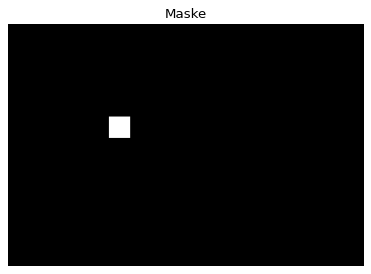

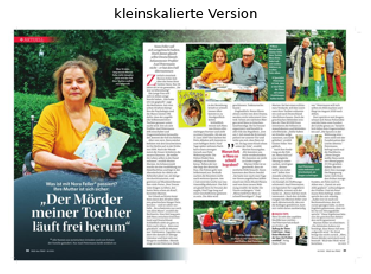

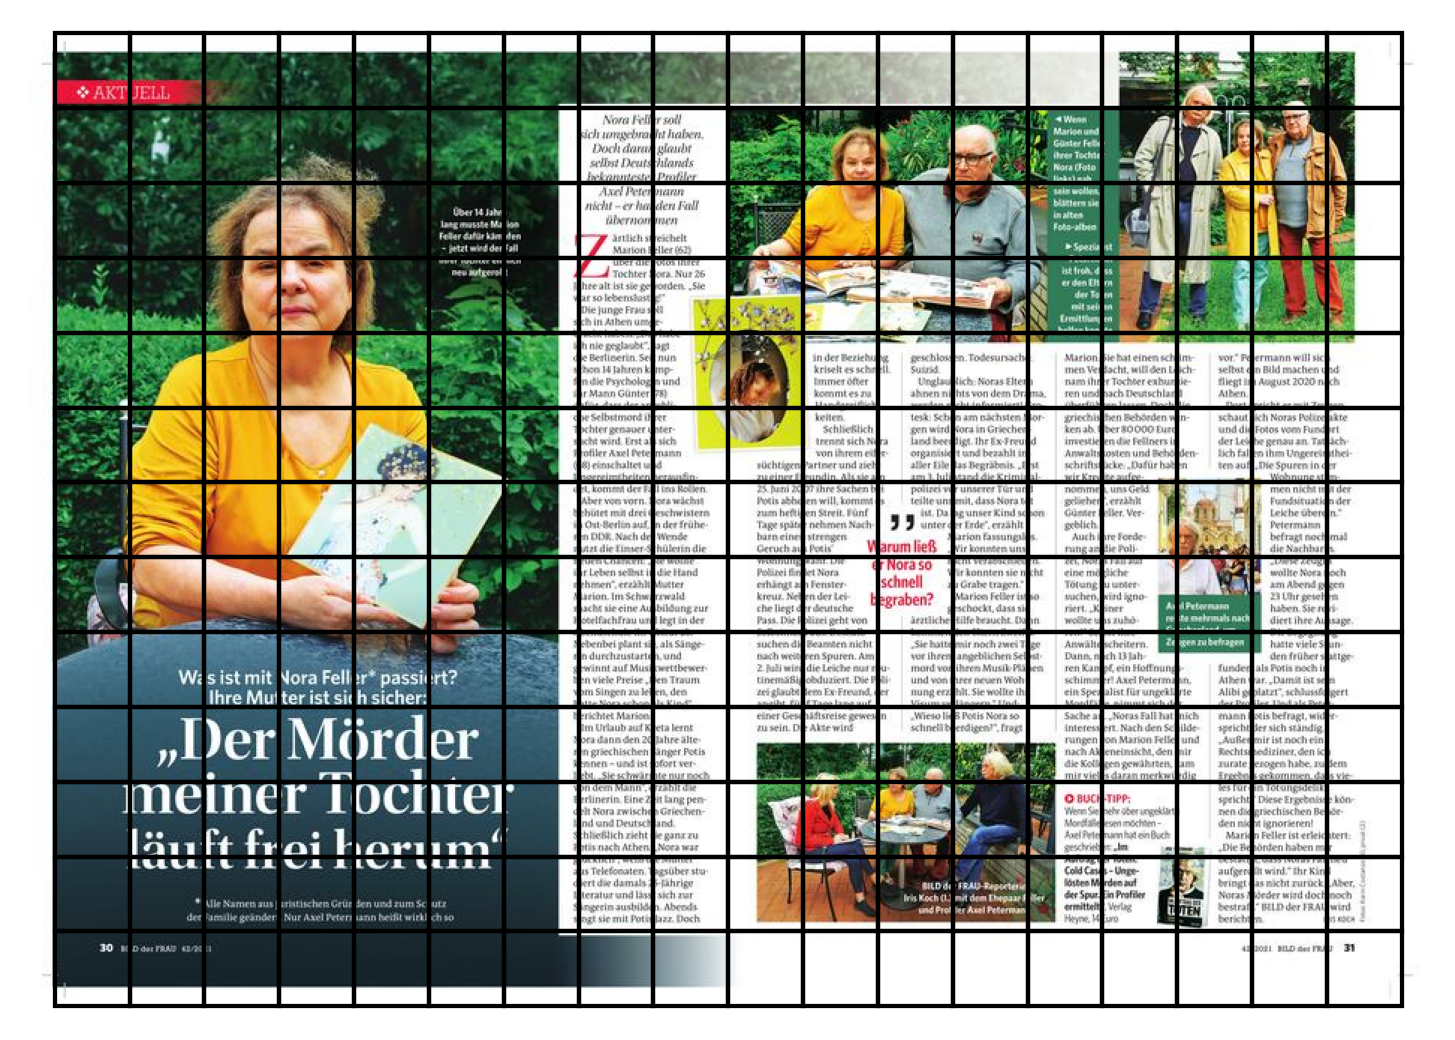

In [5]:
# Show example page with SP and Labels
patchLoader = PatchLoader(labelHelper, superPixelSize= config.SUPERPIXEL_SIZE, patchSize=config.PATCH_RADIUS) 
for i in patchLoader:
    # Show example
    a = i['patchHelper'].createMask(5,5)
    plt.rcParams['figure.dpi'] = 80
    plt.title("Maske")
    plt.imshow(a, cmap= "gray")
    plt.axis('off')
    plt.show()    
    plt.imshow(i['patchHelper'].getSmallImage(), interpolation='nearest')
    plt.title("kleinskalierte Version")
    plt.axis('off')
    plt.show()
    showImageWithLabelAndSP(i)
    break

In [8]:
if config.DEVICE == "cuda":
    cnn = NetworkResnet().cuda()
else:
    cnn = NetworkResnet()

C:\Users\Arne\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Arne\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
def create_dataset(data):
    convert_tensor = transforms.Compose(
                [transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


    dataset = DataLoaderDynamic(data, convert_tensor)
    train_loader = torch.utils.data.DataLoader(dataset=dataset,
                                                batch_size=config.BATCH_SIZE_SNN,
                                                shuffle=True)
    train_len = int(len(dataset) * 1)
    return train_loader, train_len

In [10]:
criterion = ContrastiveLoss()
counter = []
loss_history = [] 
iteration_number= 0

In [11]:
# Training the Siamese neural network

change = True
optimizer = optim.Adam(cnn.parameters(),lr = 0.0001 )

for epoch in range(0,config.EPOCHES_SNN):
    
    # use a different set of patches every iteration
    print("Loading new set of combinations")
    _, data = load_combinations()
    train_loader, train_len = create_dataset(data)

    z = 0
    
    # use a smaller learning rate for the last epoch
    if epoch == (config.EPOCHES_SNN - 1) and change:
        print("Reducing learning rate")
        optimizer = optim.Adam(cnn.parameters(),lr = 0.00001 )
        change = False
        
    print("Start training of epoch {} and a total of {} combinations".format(epoch, train_len))
    for i, (img1_set, img1_index, img2_set, img2_index, labels, filenames) in enumerate(train_loader):
        z = z + 1

        # load images to gpu
        if config.DEVICE == "cuda":
            img1_set = img1_set.cuda()
            img2_set = img2_set.cuda()
            img1_index = img1_index.cuda()
            img2_index = img2_index.cuda()
            labels = labels.cuda()

        optimizer.zero_grad()
        output1,output2 = cnn(img1_set, img1_index, img2_set, img2_index)
        loss_contrastive = criterion(output1,output2,labels)
        loss_contrastive.backward()
        optimizer.step()
        
        # show results every 100 batches
        if z %100 == 0 :
            print('100 Combinations')
            print(str(train_len - z*50) + "left")
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=100
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
        

Loading new set of combinations


KeyboardInterrupt: 

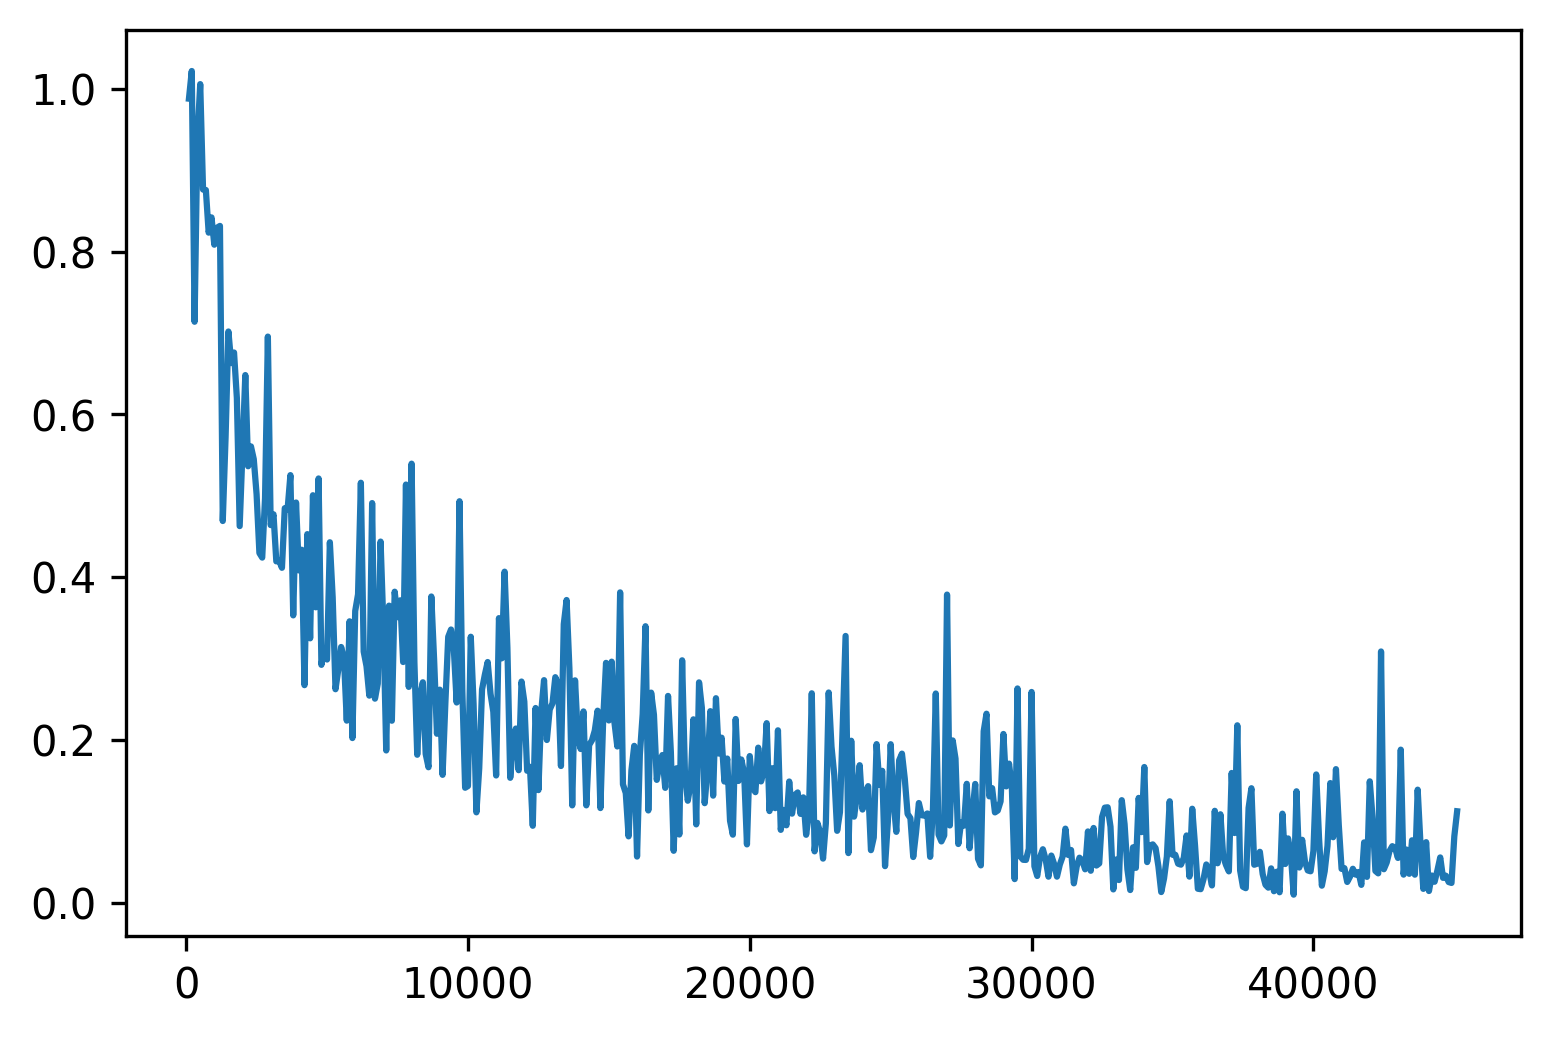

In [ ]:
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

show_plot(counter,loss_history)

In [ ]:
print(len(data))

# Save Model

torch.save(cnn.state_dict(), '../models/siamese.pth')

NameError: ignored